## Import Data ##

In [10]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np
from scipy.stats import *
import time
from skimage.transform import resize
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [12]:
#If no csv attached use this to get the audio files

audio_path = []
labels = []

for i in os.listdir("/Users/jay/Jupyter Projects/DogsvsCatsAudio/cats_dogs"):
    for label in os.listdir(f"/Users/jay/Jupyter Projects/DogsvsCatsAudio/cats_dogs/{i}"):
        for audio in os.listdir(f"/Users/jay/Jupyter Projects/DogsvsCatsAudio/cats_dogs/{i}/{label}"):
            audio_path.append(f"/Users/jay/Jupyter Projects/DogsvsCatsAudio/cats_dogs/{i}/{label}/{audio}")
            labels.append(label)

df = pd.DataFrame(zip(audio_path, labels), columns = ["audio_path", "Labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

,audio_path,Labels
0,/Users/jay/Jupyter Projects/DogsvsCatsAudio/ca...,cat
1,/Users/jay/Jupyter Projects/DogsvsCatsAudio/ca...,cat
2,/Users/jay/Jupyter Projects/DogsvsCatsAudio/ca...,cat
3,/Users/jay/Jupyter Projects/DogsvsCatsAudio/ca...,cat
4,/Users/jay/Jupyter Projects/DogsvsCatsAudio/ca...,cat
...,...,...
272,/Users/jay/Jupyter Projects/DogsvsCatsAudio/ca...,dog
273,/Users/jay/Jupyter Projects/DogsvsCatsAudio/ca...,dog
274,/Users/jay/Jupyter Projects/DogsvsCatsAudio/ca...,dog
275,/Users/jay/Jupyter Projects/DogsvsCatsAudio/ca...,dog


## Statistical Modeling ##

Shape:  (277, 2)

Counts:
 Labels
cat    164
dog    113
Name: count, dtype: int64



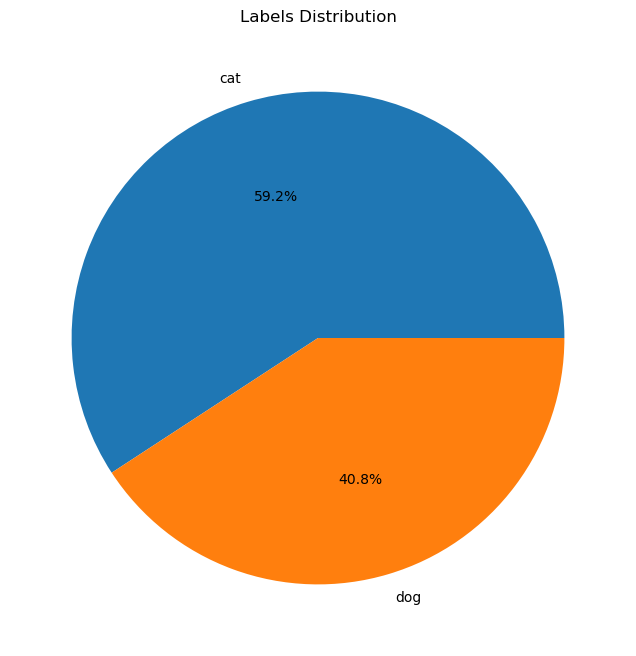

In [14]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["Labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["Labels"].value_counts(), labels = df["Labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

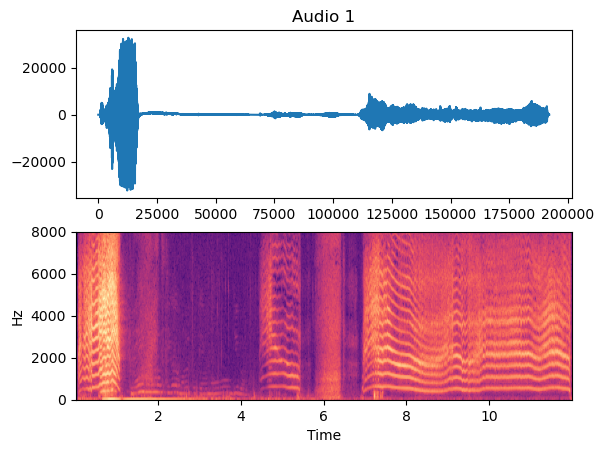

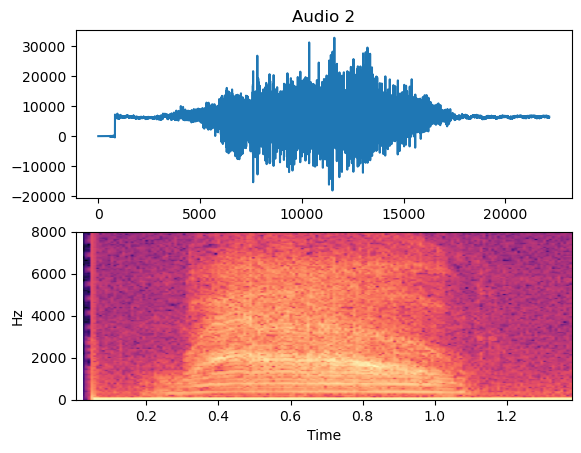

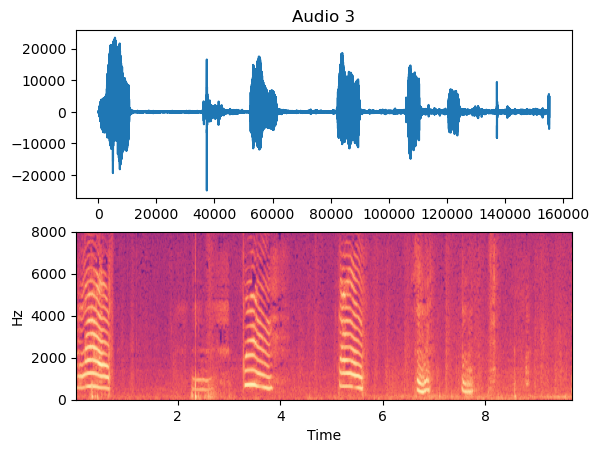

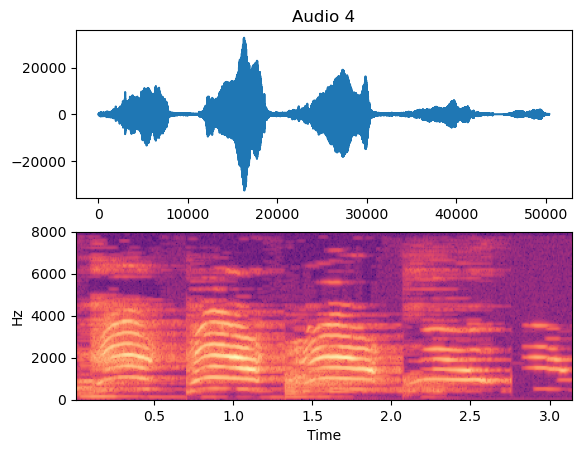

In [356]:
from scipy.io import wavfile

np.seterr(divide = "ignore") 

for i in range(4):
    samplingFrequency, signalData = wavfile.read(df.iloc[i,0])
    
    plt.subplot(211)
    plt.title(f"Audio {i+1}")
    plt.plot(signalData)
    
    plt.subplot(212)
    plt.specgram(signalData, mode="psd",Fs=samplingFrequency, cmap = "magma")
    plt.xlabel("Time")
    plt.ylabel("Hz")
    
    plt.show()

## Training Model ##

In [108]:
le = LabelEncoder()
df["Labels"] = le.fit_transform(df["Labels"])

train = df.sample(frac = 0.7, random_state = 7)
test = df.drop(train.index)

val = test.sample(frac = 0.5, random_state = 7)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(194, 2)
(41, 2)
(42, 2)


In [110]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.labels = torch.Tensor(list(dataframe["Labels"])).type(torch.LongTensor).to(device)
        self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe["audio_path"]]
        
    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = torch.Tensor(self.labels[idx]).to(device)
        audio = self.audios[idx].unsqueeze(0).to(device)
        return audio, label

    def get_spectrogram(self, file_path):
        sr = 44000
        duration = 5

        img_height = 128
        img_width = 256

        signal, sr = librosa.load(file_path, sr = sr, duration = duration)
        spec = librosa.feature.melspectrogram(y = signal, sr = sr, n_fft=2048, hop_length = 512, n_mels = 128)
        spec_db = librosa.power_to_db(spec, ref = np.max)

        spec_resized = librosa.util.fix_length(spec_db, size = (duration*sr) // 512+1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
        return spec_resized

In [112]:
train_dataset = CustomAudioDataset(dataframe = train)
val_dataset = CustomAudioDataset(dataframe = val)
test_dataset = CustomAudioDataset(dataframe = test)

In [114]:
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 10

In [116]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [118]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear((64*16*32), 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)

        self.output = nn.Linear(512, len(df["Labels"].unique()))

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        
        x = self.conv2(x)
        x = self.pooling(x)
        
        x = self.conv3(x)
        x = self.pooling(x)
        
        x = self.relu(x)

        x = x.view(x.size(0), -1)

        x = self.flatten(x)
        
        x = self.linear1(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.dropout(x)

        x = self.output(x)
        return x

In [120]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [297]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─ReLU: 1-5                              --
├─Flatten: 1-6                           --
├─Linear: 1-7                            134,221,824
├─Linear: 1-8                            4,195,328
├─Linear: 1-9                            524,800
├─Linear: 1-10                           1,026
├─Dropout: 1-11                          --
Total params: 138,966,274
Trainable params: 138,966,274
Non-trainable params: 0

In [122]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [124]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/100, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/100, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

print("Training Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch no. 1/10 
    Training Loss: 3.0612 
    Training Accuracy: 56.1856 
    Validation Loss: 0.2637 
    Validation Accuracy: 69.0476
Epoch no. 2/10 
    Training Loss: 0.8142 
    Training Accuracy: 67.5258 
    Validation Loss: 0.0383 
    Validation Accuracy: 88.0952
Epoch no. 3/10 
    Training Loss: 0.1559 
    Training Accuracy: 77.3196 
    Validation Loss: 0.0398 
    Validation Accuracy: 80.9524
Epoch no. 4/10 
    Training Loss: 0.0958 
    Training Accuracy: 88.6598 
    Validation Loss: 0.0352 
    Validation Accuracy: 83.3333
Epoch no. 5/10 
    Training Loss: 0.0632 
    Training Accuracy: 91.7526 
    Validation Loss: 0.0333 
    Validation Accuracy: 85.7143
Epoch no. 6/10 
    Training Loss: 0.0574 
    Training Accuracy: 92.268 
    Validation Loss: 0.027 
    Validation Accuracy: 85.7143
Epoch no. 7/10 
    Training Loss: 0.0374 
    Training Accuracy: 93.299 
    Validation Loss: 0.0436 
    Validation Accuracy: 90.4762
Epoch no. 8/10 
    Training Loss: 0.039 
  

In [126]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 78.0488 
Loss: 0.0


## Post-Training Analysis ##

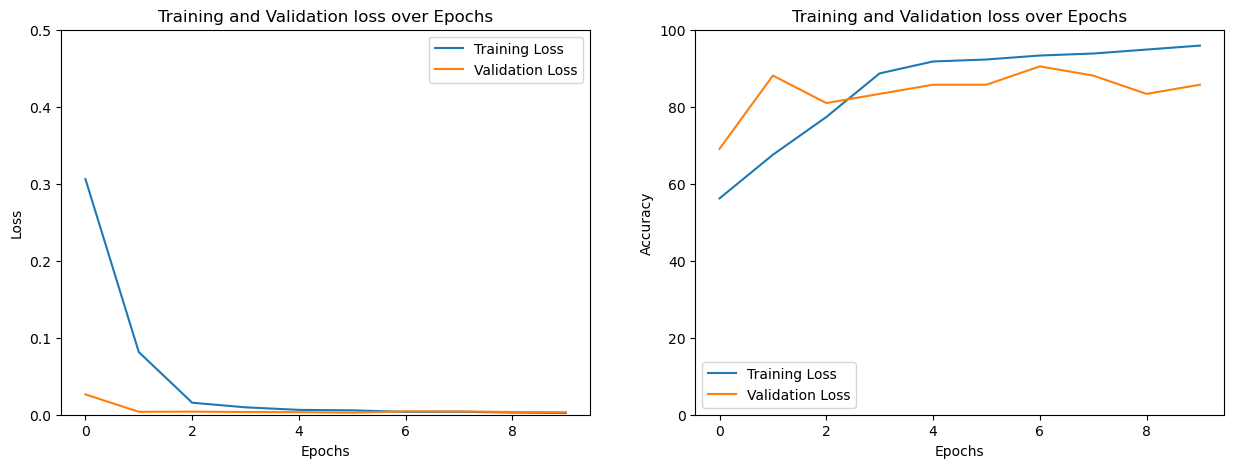

In [134]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.5])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [138]:
torch.save(model.state_dict(), "Audio.pth")

In [140]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("Audio.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)